<a href="https://colab.research.google.com/github/theclosedbook/GAN/blob/main/Cycle_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output
tf .__version__

'2.15.0'

In [2]:
import tensorflow_datasets as tfds

In [3]:
!sed -i 's/# Download FTP/url = url.replace("people.eecs.berkeley.edu\/~taesung_park\/CycleGAN\/datasets", "efrosgans.eecs.berkeley.edu\/cyclegan\/datasets") # Download FTP/' /usr/local/lib/python3.10/dist-packages/tensorflow_datasets/core/download/downloader.py

In [4]:
dataset,metadata = tfds.load('cycle_gan/apple2orange',with_info=True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/995 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/incomplete.OTP4TJ_3.0.0/cycle_gan-trainA.tfrecord*.…

Generating trainB examples...:   0%|          | 0/1019 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/incomplete.OTP4TJ_3.0.0/cycle_gan-trainB.tfrecord*.…

Generating testA examples...:   0%|          | 0/266 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/incomplete.OTP4TJ_3.0.0/cycle_gan-testA.tfrecord*..…

Generating testB examples...:   0%|          | 0/248 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/incomplete.OTP4TJ_3.0.0/cycle_gan-testB.tfrecord*..…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/3.0.0. Subsequent calls will reuse this data.


In [5]:
tf.random.set_seed(42)

In [6]:
training_A , training_B = dataset['trainA'],dataset['trainB']
testing_A , testing_B = dataset['testA'],dataset['testB']

In [7]:
quantity_training = len(training_A)
quantity_training

995

In [8]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

## Functions to preprocessing

In [9]:
def random_crop(img):
  img_crop = tf.image.random_crop(img, size=[img_width, img_height, 3])
  return img_crop

In [10]:
def normalize(img):
  img = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  return img

In [11]:
def random_jitter(img):
  img = tf.image.resize(img, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = random_crop(img)
  img = tf.image.random_flip_left_right(img)
  return img

In [12]:
def process_training_img(img, label):
  img = random_jitter(img)
  img = normalize(img)
  return img

In [13]:
def process_testing_img(img, label):
  img = normalize(img)
  return img

##Loading the dataset

In [14]:
training_A = training_A.cache().map(process_training_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
training_B = training_B.cache().map(process_training_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
testing_A = testing_A.cache().map(process_testing_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
testing_B = testing_B.cache().map(process_testing_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)

In [15]:
type(training_A)

tensorflow.python.data.ops.batch_op._BatchDataset

In [16]:
sample_A = next(iter(training_A))
sample_B = next(iter(training_B))

apple


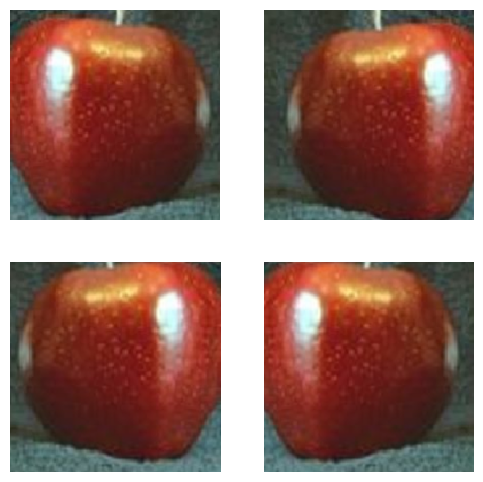

In [17]:
print("apple")
plt.figure(figsize = (6,6))
for i in range(4):
  A_jitter = random_jitter(sample_A[0])
  plt.subplot(2,2,i+1)
  plt.imshow(A_jitter * 0.5 +0.5)
  plt.axis('off')
plt.show()

oranges


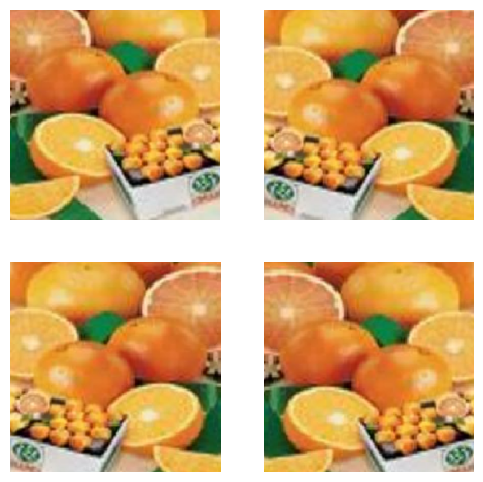

In [18]:
print("oranges")
plt.figure(figsize = (6,6))
for i in range(4):
  B_jitter = random_jitter(sample_B[0])
  plt.subplot(2,2,i+1)
  plt.imshow(B_jitter * 0.5 +0.5)
  plt.axis('off')
plt.show()

## Generator and Discriminator

1. *Instance normalization* is used instead of *batch normalization*
2. The generator is a modified ResNet - we are going to use U-net so the implementation will be simpler

In [20]:
!pip install git+https://github.com/tensorflow/examples.git


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-3btfdpe_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-3btfdpe_
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=24215152b35bf3e0955c2f636c7c07568755d13783477806bb1a74557d866a22
  Stored in directory: /tmp/pip-ephem-wheel-cache-bsli_1es/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [21]:
from tensorflow_examples.models.pix2pix import pix2pix

In [22]:
output_channels = 3
generator_g = pix2pix.unet_generator(output_channels, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(output_channels, norm_type='instancenorm')
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

CycleGAN algorithm:

* There are 2 generators (G e F) and 2 discriminators (X e Y)

1. Generator G = learn how to convert image X into image Y (`G:X->Y`)
2. Generator F = learn how to convert image Y into image X  (`F:Y->X`)
3. Discriminator D_X = learn how to classify image X and image X generated by the generator(`X(F(Y))`)
4. Discriminator D_Y = learn how to classify image Y and image Y generated by the generator (`Y(G(X))`)

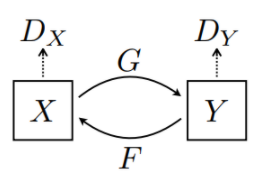

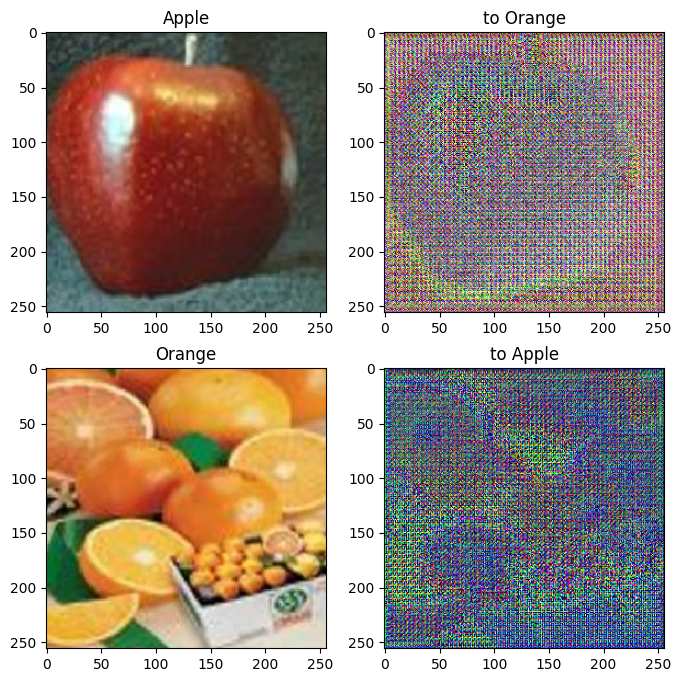

In [23]:
B_generated = generator_g(sample_A) # apple -> orange
A_generated = generator_f(sample_B) # orange -> apple
plt.figure(figsize = (8,8))
imgs = [sample_A, B_generated, sample_B, A_generated]
title = ['Apple', 'to Orange', 'Orange', 'to Apple']
for i in range(len(imgs)):
  plt.subplot(2, 2, i + 1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * 6 + 0.5)
plt.show()

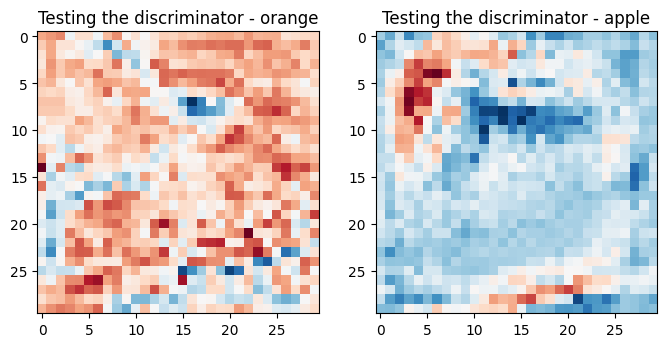

In [24]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.title('Testing the discriminator - orange')
plt.imshow(discriminator_y(sample_B)[0, ..., -1], cmap = 'RdBu_r')

plt.subplot(1, 2, 2)
plt.title('Testing the discriminator - apple')
plt.imshow(discriminator_x(sample_A)[0, ..., -1], cmap = 'RdBu_r')

plt.show()

## Loss

* Unlike Pix2Pix, when implementing CycleGAN we don't have a paired training set, so there's no guarantee that the input image X and the reference image Y are similar.

* To ensure that the network learns to do the correct mapping, the authors proposed the cycle consistency loss (*cycle consistency loss*)

In [25]:
lambda_ = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [26]:
def discriminator_loss(real, generated):
  real_loss = loss(tf.ones_like(real), real)
  generated_loss = loss(tf.zeros_like(generated), generated)
  d_total_loss = real_loss + generated_loss
  return d_total_loss

In [27]:
def generator_loss(generated):
  return loss(tf.ones_like(generated), generated)

> Cycle consistency loss - means that the result should be close to the original (input) image. Example: if we translate a sentence from Portuguese to English, and then translate it again from English to Portuguese, the result must be the same as the original sentence.

Steps:

* Image X is sent to generator G that creates image Y^
* Generated image Ŷ is sent to generator F that creates image X^ "cycled"
* Mean Absolute Error is calculated between X e X^

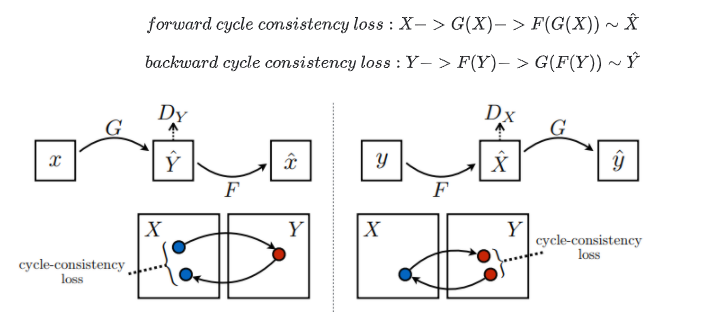

In [28]:
def cycle_loss(real_img,cycled_img):
  loss1 = tf.reduce_mean(tf.abs(real_img - cycled_img))
  return lambda_ * loss1

In short:

* Generator G is responsible for translating image X to Y

* Identity loss: if you send Y image to the generator G, it should generate image Y or something similar to image Y

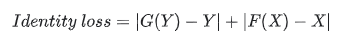

In [29]:
def identity_loss(real_img, equal_img):
  loss = tf.reduce_mean(tf.abs(real_img - equal_img))
  return lambda_ * 0.5 * loss

## Optimizers

In [30]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
optimizer_generator_g = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
optimizer_generator_f = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

optimizer_discriminator_x = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
optimizer_discriminator_y = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [31]:
epochs = 10
def generate_images(model, test_input):
  generated = model(test_input)
  plt.figure(figsize = (8,6))
  list_imgs = [test_input[0], generated[0]]
  title = ['Original', 'Output (generated)']
  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    plt.imshow(list_imgs[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [32]:
@tf.function
def training_step(real_x, real_y): # apple, orange
  with tf.GradientTape(persistent=True) as tape:
    # Generator G: X -> Y
    # Generator F: Y -> X

    # Apple into an orange fake
    fake_y = generator_g(real_x, training = True)
    # Cycle (apple into orange, orange into apple fake) x -> y -> x
    cycled_x = generator_f(fake_y, training = True)

    # Orange into an apple fake
    fake_x = generator_f(real_y, training = True)
    # Cycle (orange into apple fake, apple into orange fake) y -> x -> y
    cycled_y = generator_g(fake_x, training = True)

    # Identity mapping
    equal_x = generator_f(real_x, training = True)
    equal_y = generator_g(real_y, training = True)

    # Discriminator outputs
    discriminator_real_x = discriminator_x(real_x, training = True)
    discriminator_fake_x = discriminator_x(fake_x, training = True)
    discriminator_real_y = discriminator_y(real_y, training = True)
    discriminator_fake_y = discriminator_y(fake_y, training = True)

    # Loss calculation
    generator_g_loss = generator_loss(discriminator_fake_y)
    generator_f_loss = generator_loss(discriminator_fake_x)
    cycle_loss_total = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
    total_generator_g_loss = generator_g_loss + cycle_loss_total + identity_loss(real_y, equal_y)
    total_generator_f_loss = generator_f_loss + cycle_loss_total + identity_loss(real_x, equal_x)
    discriminator_x_loss = discriminator_loss(discriminator_real_x, discriminator_fake_x)
    discriminator_y_loss = discriminator_loss(discriminator_real_y, discriminator_fake_y)

  # Gradients
  generator_g_gradients = tape.gradient(total_generator_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_generator_f_loss, generator_f.trainable_variables)
  discriminator_x_gradients = tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)

  # Optimizer
  optimizer_generator_g.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  optimizer_generator_f.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
  optimizer_discriminator_x.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  optimizer_discriminator_y.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [33]:
def train(training_A, training_B, generator_g, steps):
  for epoch in range(epochs):
    start = time.time()
    n = 0
    for img_x, img_y in tf.data.Dataset.zip((training_A, training_B)):
      training_step(img_x, img_y)
      if n % 10 == 0:
        print('.', end = '')
      n += 1

    clear_output(wait = True)
    generate_images(generator_g, sample_A)
    print('Time taken to train epoch {}: {} seconds\n'.format(epoch + 1, time.time() - start))
    generator_g.save_weights('model_cyclegan.h5')

In [ ]:
train(training_A, training_B, generator_g, epochs)

...........................................................................................